<a href="https://colab.research.google.com/github/bhav09/covid-19/blob/master/Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [7]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/with_mask/
  inflating: dataset/with_mask/0-with-mask.jpg  
  inflating: dataset/with_mask/100-with-mask.jpg  
  inflating: dataset/with_mask/101-with-mask.jpg  
  inflating: dataset/with_mask/103-with-mask.jpg  
  inflating: dataset/with_mask/104-with-mask.jpg  
  inflating: dataset/with_mask/105-with-mask.jpg  
  inflating: dataset/with_mask/106-with-mask.jpg  
  inflating: dataset/with_mask/107-with-mask.jpg  
  inflating: dataset/with_mask/108-with-mask.jpg  
  inflating: dataset/with_mask/109-with-mask.jpg  
  inflating: dataset/with_mask/10-with-mask.jpg  
  inflating: dataset/with_mask/110-with-mask.jpg  
  inflating: dataset/with_mask/111-with-mask.jpg  
  inflating: dataset/with_mask/112-with-mask.jpg  
  inflating: dataset/with_mask/113-with-mask.jpg  
  inflating: dataset/with_mask/114-with-mask.jpg  
  inflating: dataset/with_mask/115-with-mask.jpg  
  inflating: dataset/with_mask/116-with-mask.jpg  
  inflating: dataset/with_mask/

In [21]:
dir='/content/sample_data/dataset'
print('Done')

Done


In [0]:
lr = 1e-4
epochs = 20
Batch_Size = 32

In [0]:
path=[]
for root, dirs, files in os.walk(os.path.abspath(dir)):
    for file in files:
        #print(os.path.join(root, file))
        path.append(os.path.join(root, file))
        

In [0]:
imagePaths = path #giving all the paths to a new variable 
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [0]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [30]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [35]:
print("Compiling Model...")
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
print("training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=Batch_Size),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=epochs)

Compiling Model...
training head...
Epoch 1/20
34/34 [==============================] - 55s 2s/step - loss: 0.5892 - accuracy: 0.7022 - val_loss: 0.1741 - val_accuracy: 0.9638
Epoch 2/20
34/34 [==============================] - 54s 2s/step - loss: 0.1632 - accuracy: 0.9457 - val_loss: 0.0705 - val_accuracy: 0.9819
Epoch 3/20
34/34 [==============================] - 53s 2s/step - loss: 0.0963 - accuracy: 0.9663 - val_loss: 0.0418 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 52s 2s/step - loss: 0.0732 - accuracy: 0.9785 - val_loss: 0.0298 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 53s 2s/step - loss: 0.0410 - accuracy: 0.9869 - val_loss: 0.0243 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 56s 2s/step - loss: 0.0399 - accuracy: 0.9878 - val_loss: 0.0210 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 53s 2s/step - loss: 0.0368 - accuracy: 0.9916 - val_loss: 0.0174 - val_a

In [36]:
print("[INFO] evaluating network...")
y_pred = model.predict(testX, batch_size=Batch_Size)

[INFO] evaluating network...


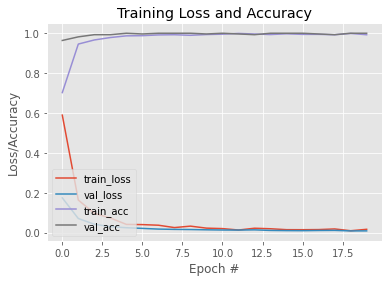

In [39]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])